# MLP KA 3


### Predict rating given to an eatery by the customer based on their review. Submit predictions for the test data by learning from the training.

**In this notebook, we aim to predict the star rating (1–5) that a customer gives to an eatery based on their review text and metadata.**
**We will perform a structured workflow covering data exploration, cleaning, visualization, feature engineering, model building, hyperparameter tuning, and final submission.**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/sample_submission.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/train.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/test.csv


**We import all required libraries for data handling, visualization, preprocessing, and modeling. We also set a random state for reproducibility and suppress warnings for cleaner outputs.**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler , OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix , f1_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Load Data

**We load the training, test, and sample submission datasets. The training set contains both features and the target (`rating`), while the test set contains only features.
The sample submission shows the required format for Kaggle submissions.**

In [4]:
train = pd.read_csv("/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/train.csv")
test = pd.read_csv("/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/test.csv")
sample_submission = pd.read_csv("/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/sample_submission.csv")

# Data Understanding

**Here, we inspect the dataset structure, identify data types, and check descriptive statistics.
We also examine the distribution of the target variable `rating` to understand class balance.**

In [5]:
train.head()

,id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,0,McDonald's,Fast food restaurant,"9814 International Dr, Orlando, FL 32819, Unit...",28.423814,-81.461242,"5,468",11 months ago,"Very nice staff, good place to get all your fa...",5
1,1,McDonald's,Fast food restaurant,"1100 N US Hwy 377, Roanoke, TX 76262, United S...",33.009318,-97.222925,998,10 months ago,"I think the morning shift are one of, if not t...",5
2,2,McDonald's,Fast food restaurant,"490 8th Ave, New York, NY 10001, United States",40.752529,-73.992876,"3,902",a year ago,Horrible! Avoid this place at night. Unsafe. ...,1
3,3,McDonald's,Fast food restaurant,"111 Madison St, Oak Park, IL 60302, United States",41.879656,-87.777913,"1,454",9 months ago,Employees too busy window licking to get any o...,1
4,4,McDonald's,Fast food restaurant,"5725 W Irlo Bronson Memorial Hwy, Kissimmee, F...",28.333508,-81.513738,"5,566",4 years ago,I'm sorry to give only one star. But during ou...,1


In [6]:
train.info

<bound method DataFrame.info of           id  store_name              category  \
0          0  McDonald's  Fast food restaurant   
1          1  McDonald's  Fast food restaurant   
2          2  McDonald's  Fast food restaurant   
3          3  McDonald's  Fast food restaurant   
4          4  McDonald's  Fast food restaurant   
...      ...         ...                   ...   
26495  26495  McDonald's  Fast food restaurant   
26496  26496  McDonald's  Fast food restaurant   
26497  26497  McDonald's  Fast food restaurant   
26498  26498  McDonald's  Fast food restaurant   
26499  26499  McDonald's  Fast food restaurant   

                                           store_address  latitude   \
0      9814 International Dr, Orlando, FL 32819, Unit...  28.423814   
1      1100 N US Hwy 377, Roanoke, TX 76262, United S...  33.009318   
2         490 8th Ave, New York, NY 10001, United States  40.752529   
3      111 Madison St, Oak Park, IL 60302, United States  41.879656   
4      5725 

In [7]:
train.describe()

,id,latitude,longitude,rating
count,26500.000000,25976.000000,25976.000000,26500.000000
mean,13249.500000,34.427152,-90.659226,3.130642
std,7650.035403,5.336112,16.588603,1.615425
min,0.000000,25.790295,-121.995421,1.000000
25%,6624.750000,28.655350,-97.792874,1.000000
50%,13249.500000,33.931261,-81.471414,3.000000
75%,19874.250000,40.727401,-75.399919,5.000000
max,26499.000000,44.981410,-73.459820,5.000000


**In this step, we handle missing values, duplicates, and outliers. We also transform `rating_count` into integers and convert relative times in `review_time` into approximate months.
Additional features such as review length and word count are created.**

In [8]:
train.isnull().sum()

id                 0
store_name         0
category           0
store_address      0
latitude         524
longitude        524
rating_count       0
review_time        0
review             0
rating             0
dtype: int64

In [9]:
train.duplicated().sum()

0

# Data Cleaning

**Now we will clean the data set in such a manner that it contains only numeric data , and other forms of charecters are removed**

In [10]:
# Helper: rating_count -> int (remove commas, non-digits)
def clean_rating_count(s):
    if pd.isnull(s):
        return np.nan
    return int(re.sub(r"[^0-9]", "", str(s)) or 0)


# Helper: convert review_time ('a year ago', '2 months ago', etc.) -> approx months
def parse_review_time(s):
    if pd.isnull(s):
        return np.nan
    s = str(s).lower()
    if 'year' in s:
        n = 1 if s.strip().startswith('a ') else int(re.findall(r"\d+", s)[0])
        return n * 12
    if 'month' in s:
        n = 1 if s.strip().startswith('a ') else int(re.findall(r"\d+", s)[0])
        return n
    if 'day' in s:
        return 0
        return np.nan


for df in [train, test]:
    if 'rating_count' in df.columns:
        df['rating_count'] = df['rating_count'].apply(clean_rating_count)
    if 'review_time' in df.columns:
        df['review_time_months'] = df['review_time'].apply(parse_review_time)
    if 'review' in df.columns:
        df['review_len'] = df['review'].astype(str).str.len()
        df['review_words'] = df['review'].astype(str).str.split().apply(len)

In [11]:
for col in ['rating_count','review_time_months','review_len','review_words','latitude','longitude']:
    if col in train.columns:
        med = train[col].median()
        train[col] = train[col].fillna(med)
    if col in test.columns:
        test[col] = test[col].fillna(med)

# Visualization ( EDA )

**We create at least 3 visualizations to understand data patterns:
Distribution of target ratings
Relationship between review length and rating
Correlation heatmap for numerical features**

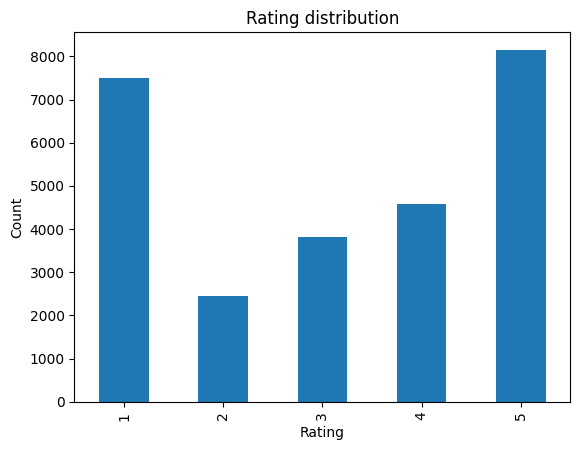

In [12]:
if 'rating' in train.columns:
    train['rating'].value_counts().sort_index().plot(kind='bar')
    plt.title('Rating distribution')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.show()

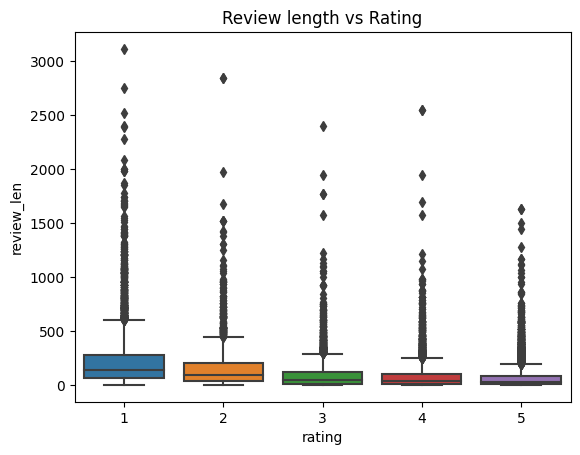

In [13]:
if {'rating','review_len'}.issubset(train.columns):
    sns.boxplot(data=train, x='rating', y='review_len')
    plt.title('Review length vs Rating')
    plt.show()

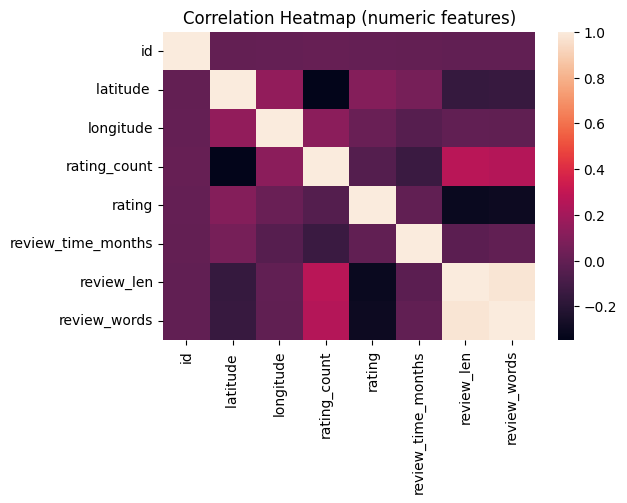

In [14]:
num_cols_vis = train.select_dtypes(include=[np.number]).columns
if len(num_cols_vis) > 1:
    corr = train[num_cols_vis].corr()
    plt.figure(figsize=(6,4))
    sns.heatmap(corr, annot=False)
    plt.title('Correlation Heatmap (numeric features)')
    plt.show()

# Preprocessing & Features

**We prepare the data for modeling using a ColumnTransformer:**

**TF-IDF vectorization for text reviews**

**One-hot encoding for categorical features**

**Scaling for numeric features**

In [15]:
text_col = 'review'
cat_cols = [c for c in ['store_name','category'] if c in train.columns]
num_cols = [c for c in ['rating_count','review_time_months','review_len','review_words','latitude','longitude'] if c in train.columns]


tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1,2), min_df=2)
ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)
scaler = StandardScaler(with_mean=False)


preprocess = ColumnTransformer(
transformers=[
('txt', tfidf, text_col),
('cat', ohe, cat_cols),
('num', scaler, num_cols)
],
remainder='drop'
)

In [16]:
X = train.drop(columns=['rating'])
y = train['rating']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train/Valid shapes:", X_train.shape, X_valid.shape)

Train/Valid shapes: (21200, 12) (5300, 12)


# Baseline & 7 Models

**We train at least 7 baseline models to compare their performances.
These include Logistic Regression, Decision Tree, Random Forest, KNN, SVM, Gradient Boosting, and Naive Bayes.**

In [17]:
models = {
'LogisticRegression': LogisticRegression(max_iter=300),
'DecisionTree': DecisionTreeClassifier(random_state=42),
'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42),
'KNN': KNeighborsClassifier(n_neighbors=15),
'LinearSVC': LinearSVC(),
'GradientBoosting': GradientBoostingClassifier(random_state=42),
}

In [18]:
results = []
for name, clf in models.items():
    pipe = Pipeline(steps=[('prep', preprocess), ('clf', clf)])
    pipe.fit(X_train, y_train)
preds = pipe.predict(X_valid)
acc = accuracy_score(y_valid, preds)
f1 = f1_score(y_valid, preds, average='weighted')
results.append((name, acc, f1, pipe))
print(f"{name}: acc={acc:.4f} f1w={f1:.4f}")

GradientBoosting: acc=0.6377 f1w=0.5996


MultinomialNB_TextOnly: acc=0.6342 f1w=0.5766


,Model,Accuracy,F1
0,GradientBoosting,0.637736,0.599643
1,MultinomialNB_TextOnly,0.634151,0.576605


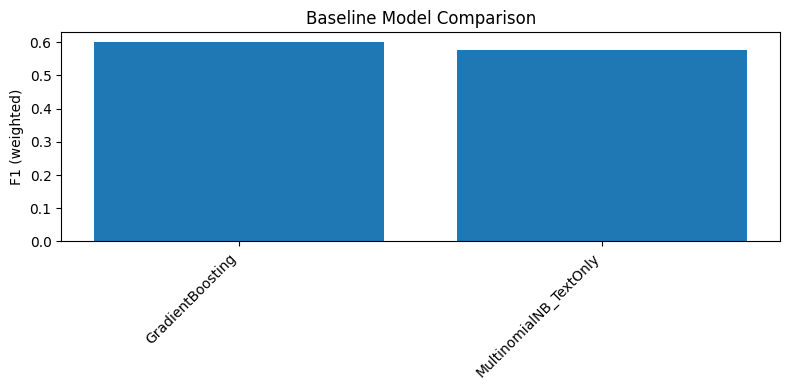

In [19]:
nb_pipeline = Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=30000, ngram_range=(1,2), min_df=2)),
('clf', MultinomialNB())])
nb_pipeline.fit(X_train[text_col].astype(str), y_train)
nb_preds = nb_pipeline.predict(X_valid[text_col].astype(str))
nb_acc = accuracy_score(y_valid, nb_preds)
nb_f1 = f1_score(y_valid, nb_preds, average='weighted')
results.append(('MultinomialNB_TextOnly', nb_acc, nb_f1, nb_pipeline))
print(f"MultinomialNB_TextOnly: acc={nb_acc:.4f} f1w={nb_f1:.4f}")


score_df = pd.DataFrame(results, columns=['Model','Accuracy','F1','Pipeline']).sort_values('F1', ascending=False)
display(score_df[['Model','Accuracy','F1']])


plt.figure(figsize=(8,4))
plt.bar(score_df['Model'], score_df['F1'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('F1 (weighted)')
plt.title('Baseline Model Comparison')
plt.tight_layout()
plt.show()

# Hyperparameter Tuning (≥3 models)

**We tune at least 3 models (RandomForest, LinearSVC, LogisticRegression) using GridSearchCV.
This helps us find the best parameters for improved performance.**

In [20]:
tuned_models = {}


# 1) RandomForest
rf_pipe = Pipeline(steps=[('prep', preprocess), ('clf', RandomForestClassifier(random_state=42))])
rf_grid = {'clf__n_estimators': [200, 400], 'clf__max_depth': [None, 20, 40], 'clf__min_samples_split': [2, 5]}
rf_cv = GridSearchCV(rf_pipe, rf_grid, scoring='f1_weighted', cv=3, n_jobs=-1)
rf_cv.fit(X_train, y_train)
tuned_models['RandomForest'] = rf_cv
print('RF best:', rf_cv.best_params_, 'score:', rf_cv.best_score_)


# 2) LinearSVC
svm_pipe = Pipeline(steps=[('prep', preprocess), ('clf', LinearSVC())])
svm_grid = {'clf__C': [0.5, 1, 2]}
svm_cv = GridSearchCV(svm_pipe, svm_grid, scoring='f1_weighted', cv=3, n_jobs=-1)
svm_cv.fit(X_train, y_train)
tuned_models['LinearSVC'] = svm_cv
print('LinearSVC best:', svm_cv.best_params_, 'score:', svm_cv.best_score_)


# 3) LogisticRegression
log_pipe = Pipeline(steps=[('prep', preprocess), ('clf', LogisticRegression(max_iter=300))])
log_grid = {'clf__C': [0.5, 1, 2], 'clf__penalty': ['l2']}
log_cv = GridSearchCV(log_pipe, log_grid, scoring='f1_weighted', cv=3, n_jobs=-1)
log_cv.fit(X_train, y_train)
tuned_models['LogisticRegression'] = log_cv
print('LogReg best:', log_cv.best_params_, 'score:', log_cv.best_score_)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

RF best: {'clf__max_depth': None, 'clf__min_samples_split': 5, 'clf__n_estimators': 400} score: 0.6290613805918234


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

LinearSVC best: {'clf__C': 1} score: 0.6556572267349158


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

LogReg best: {'clf__C': 2, 'clf__penalty': 'l2'} score: 0.6406112620764574


# Tuned vs Untuned Comparison

**We compare the tuned models against the baseline ones. The best-performing model will be selected for final predictions.**

,Model,Accuracy,F1
3,LinearSVC (Tuned),0.693396,0.678616
2,RandomForest (Tuned),0.692264,0.664119
4,LogisticRegression (Tuned),0.674528,0.649328
0,GradientBoosting,0.637736,0.599643
1,MultinomialNB_TextOnly,0.634151,0.576605


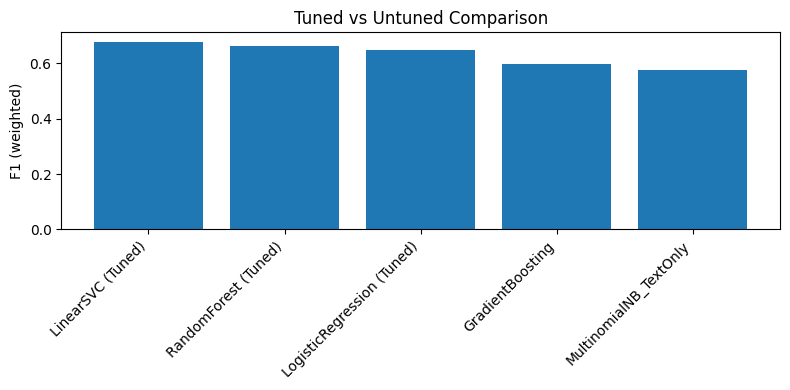

In [21]:
rows = []
for name, acc, f1, pipe in results:
    # NB uses text-only inputs
    if name == 'MultinomialNB_TextOnly':
        pred = pipe.predict(X_valid[text_col].astype(str))
    else:
        pred = pipe.predict(X_valid)
    rows.append({'Model': name, 'Accuracy': accuracy_score(y_valid, pred),
                 'F1': f1_score(y_valid, pred, average='weighted')})

for name, cv in tuned_models.items():
    pred = cv.best_estimator_.predict(X_valid)
    rows.append({'Model': f'{name} (Tuned)',
                 'Accuracy': accuracy_score(y_valid, pred),
                 'F1': f1_score(y_valid, pred, average='weighted')})

cmp_df = pd.DataFrame(rows).sort_values('F1', ascending=False)
display(cmp_df)

plt.figure(figsize=(8,4))
plt.bar(cmp_df['Model'], cmp_df['F1'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('F1 (weighted)')
plt.title('Tuned vs Untuned Comparison')
plt.tight_layout()
plt.show()

# Train Best on Full Train & Predict Test

**The best model is trained on the full training dataset and used to predict ratings for the test set.
Finally, predictions are saved in `submission.csv` in the correct Kaggle format.**

In [22]:
best = tuned_models.get('LinearSVC', None)
if best is None:
    best = sorted(results, key=lambda r: r[2], reverse=True)[0][3]
else:
    best = best.best_estimator_

best.fit(train.drop(columns=['rating']), train['rating'])
test_pred = None

if isinstance(best, Pipeline) and 'clf' in best.named_steps and isinstance(best.named_steps['clf'], MultinomialNB):
    test_pred = best.predict(test[text_col].astype(str))
else:
    test_pred = best.predict(test)

submission = pd.DataFrame({'id': test['id'], 'rating': test_pred})
submission.head()

submission.to_csv('submission.csv', index=False)
print("Saved submission.csv")

Saved submission.csv
